In [150]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer , scale
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from keras.models import Model


from IPython.display import SVG
from urllib.request import urlretrieve
import zipfile
import collections

In [151]:
df_ratings = pd.read_csv("ratings.csv", index_col=False)

In [152]:
df_ratings

,Unnamed: 0,userID,genreID,ratings
0,0,0,0,0.0
1,1,0,1,0.0
2,2,0,2,0.0
3,3,0,3,0.0
4,4,0,4,0.0
...,...,...,...,...
345,345,49,2,0.0
346,346,49,3,0.0
347,347,49,4,1.0
348,348,49,5,1.0


In [153]:
min_rating = min(df_ratings["ratings"])
max_rating = max(df_ratings["ratings"])

train, test = train_test_split(df_ratings, test_size=0.1)

ROW_COUNT = train.shape[0]

EMBEDDING_SIZE = 10
NUM_USERS = df_ratings['userID'].nunique()
NUM_GENRES = df_ratings['genreID'].nunique()

UNIQUE_GENRE_IDS = df_ratings['genreID'].unique()

In [154]:
def EmbeddingRec(EMBEDDING_SIZE, NUM_GENRES, NUM_USERS, ROW_COUNT):
    genre_input = keras.Input(shape=(1,), name='genreID')

    genre_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_GENRES, input_length=ROW_COUNT, name='genre_emb')(genre_input)
    genre_vec = layers.Flatten(name='FlattenGenre')(genre_emb)

    genre_model = keras.Model(inputs=genre_input, outputs=genre_vec)
    
    user_input = keras.Input(shape=(1,), name='userID')

    user_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, input_length=ROW_COUNT, name='user_emb')(user_input)
    user_vec = layers.Flatten(name='FlattenUser')(user_emb)

    user_model = keras.Model(inputs=user_input, outputs=user_vec)
    
    merged = layers.Dot(name = 'dot_product', normalize = True, axes = 2)([genre_emb, user_emb])
    merged_dropout = layers.Dropout(0.2)(merged)
    
    
    dense_1 = layers.Dense(70,name='FullyConnected-1')(merged)
    dropout_1 = layers.Dropout(0.2,name='Dropout_1')(dense_1)

    dense_2 = layers.Dense(50,name='FullyConnected-2')(dropout_1)
    dropout_2 = layers.Dropout(0.2,name='Dropout_2')(dense_2)

    dense_3 = keras.layers.Dense(20,name='FullyConnected-3')(dropout_2)
    dropout_3 = keras.layers.Dropout(0.2,name='Dropout_3')(dense_3)

    dense_4 = keras.layers.Dense(10,name='FullyConnected-4', activation='relu')(dropout_3)

    result = layers.Dense(1, name='result', activation="relu") (dense_4)

    adam = keras.optimizers.Adam(lr=0.001)
    model = keras.Model([genre_input, user_input], result)
    model.compile(optimizer=adam,loss= 'mean_absolute_error')
    return model, genre_model, user_model


model, genre_model, user_model = EmbeddingRec(EMBEDDING_SIZE, NUM_GENRES, NUM_USERS, ROW_COUNT)



callbacks = [keras.callbacks.EarlyStopping('val_loss', patience=10),
             keras.callbacks.ModelCheckpoint('besttest.h5', save_best_only=True)]

history = model.fit([train.genreID, train.userID],train.ratings, batch_size=50,
                              epochs = 10, validation_data = ([test.genreID, test.userID],test.ratings),
                              verbose = 1, 
                              callbacks = callbacks)





C:\Data\Programming\Anaconda\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/10
7/7 [==============================] - 1s 34ms/step - loss: 0.6681 - val_loss: 0.6571
Epoch 2/10
7/7 [==============================] - 0s 4ms/step - loss: 0.6653 - val_loss: 0.6571
Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.6635 - val_loss: 0.6571
Epoch 4/10
7/7 [==============================] - 0s 4ms/step - loss: 0.6614 - val_loss: 0.6571
Epoch 5/10
7/7 [==============================] - 0s 4ms/step - loss: 0.6605 - val_loss: 0.6571
Epoch 6/10
7/7 [==============================] - 0s 4ms/step - loss: 0.6617 - val_loss: 0.6567
Epoch 7/10
7/7 [==============================] - 0s 4ms/step - loss: 0.6584 - val_loss: 0.6805
Epoch 8/10
7/7 [==============================] - 0s 4ms/step - loss: 0.6405 - val_loss: 0.6967
Epoch 9/10
7/7 [==============================] - 0s 4ms/step - loss: 0.6057 - val_loss: 0.7523
Epoch 10/10
7/7 [==============================] - 0s 4ms/step - loss: 0.5435 - val_loss: 0.7861


In [155]:
model.summary()

Model: "model_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
genreID (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
userID (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
genre_emb (Embedding)           (None, 1, 10)        70          genreID[0][0]                    
__________________________________________________________________________________________________
user_emb (Embedding)            (None, 1, 10)        500         userID[0][0]                     
___________________________________________________________________________________________

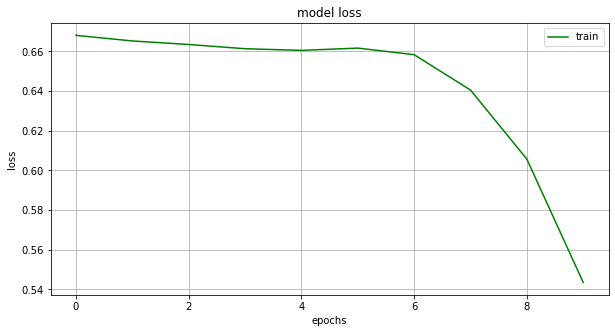

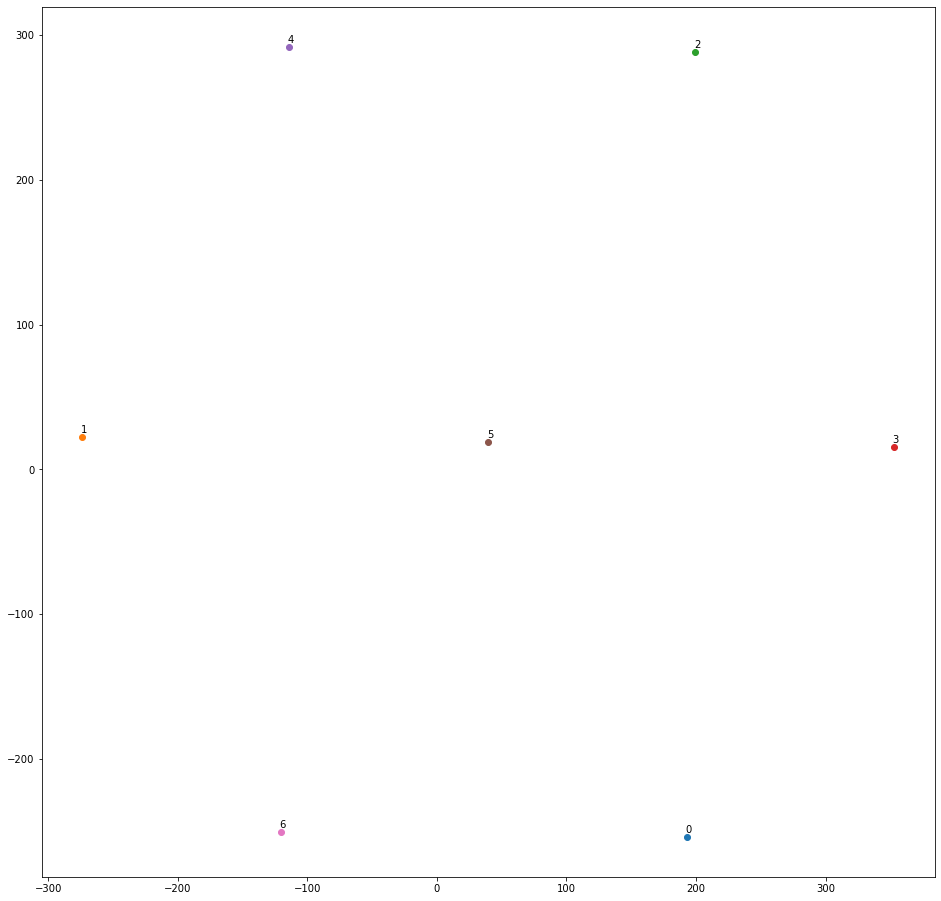

In [156]:


from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(history.history['loss'] , 'g')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train'], loc='upper right')
plt.grid(True)
plt.show()


# TEST_GENRE_ID = 5

GENRE_EMBEDDING_LIST = []
GENRE_EMBED_MAP = collections.defaultdict()

for _id in UNIQUE_GENRE_IDS:
    emb = genre_model.predict(np.array([_id]))
    val = list(emb.reshape(1,-1))[0]
    GENRE_EMBEDDING_LIST.insert(_id, val)
    GENRE_EMBED_MAP[_id] = val

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt




def tsne_plot(model, GENRE_EMBEDDING_LIST, size = NUM_GENRES):
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(GENRE_EMBEDDING_LIST[:size])
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    labels = list(range(0,size))
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],xy=(x[i], y[i]),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')
    plt.show()


tsne_plot(model, GENRE_EMBEDDING_LIST)








In [189]:
df_genres = pd.read_csv("genres.csv")

In [173]:
knn_train_label = UNIQUE_GENRE_IDS


from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(GENRE_EMBEDDING_LIST, knn_train_label)


def recommend_genres(embedding):
    distances, indices = clf.kneighbors(embedding.reshape(1, -1),  n_neighbors=5)
    indices = indices.reshape(5,1)
    df_indices = pd.DataFrame(indices, columns = ['genreID'])
    return df_indices.merge(df_genres,on='genreID',how='inner',suffixes=['_u', '_m'])['genreID']

TEST_USER_ID = 0

user_embedding = user_model.predict([TEST_USER_ID]).reshape(1,-1)[0]

recommend_genres(user_embedding)

0    0
1    1
2    5
3    6
4    4
Name: genreID, dtype: int64

In [159]:
np.average(df_ratings.loc[df_ratings['genreID'] == 5, 'ratings'], axis=0)


2.44

In [160]:
np.average(df_ratings.loc[df_ratings['genreID'] == 6, 'ratings'], axis=0)


1.54

In [161]:
np.average(df_ratings.loc[df_ratings['genreID'] == 4, 'ratings'], axis=0)


0.5

In [190]:
df_users = pd.read_csv("users.csv")
df_users = df_users["Names"]

In [191]:
df_genres_series = df_genres["genre"]

In [201]:
df_predict_matches = pd.DataFrame(columns=["userID", "user", "genre_match"])
userID_list = []
user_list = []
genre_match_list = []
for userID, user in enumerate(df_users):
    userID_list.append(userID)
    user_list.append(user)
    TEST_USER_ID = userID

    user_embedding = user_model.predict([TEST_USER_ID]).reshape(1,-1)[0]

    recommended_series = recommend_genres(user_embedding)
    genre_match = df_genres_series[recommended_series[0]]
    genre_match_list.append(genre_match)

In [204]:
df_predict_matches["userID"] = userID_list
df_predict_matches["user"] = user_list
df_predict_matches["genre_match"] = genre_match_list

In [205]:
df_predict_matches.to_csv("ahfdlkasjhdfljahsdlfjhasljfh.csv")